# 人物画像から骨格座標を抽出する
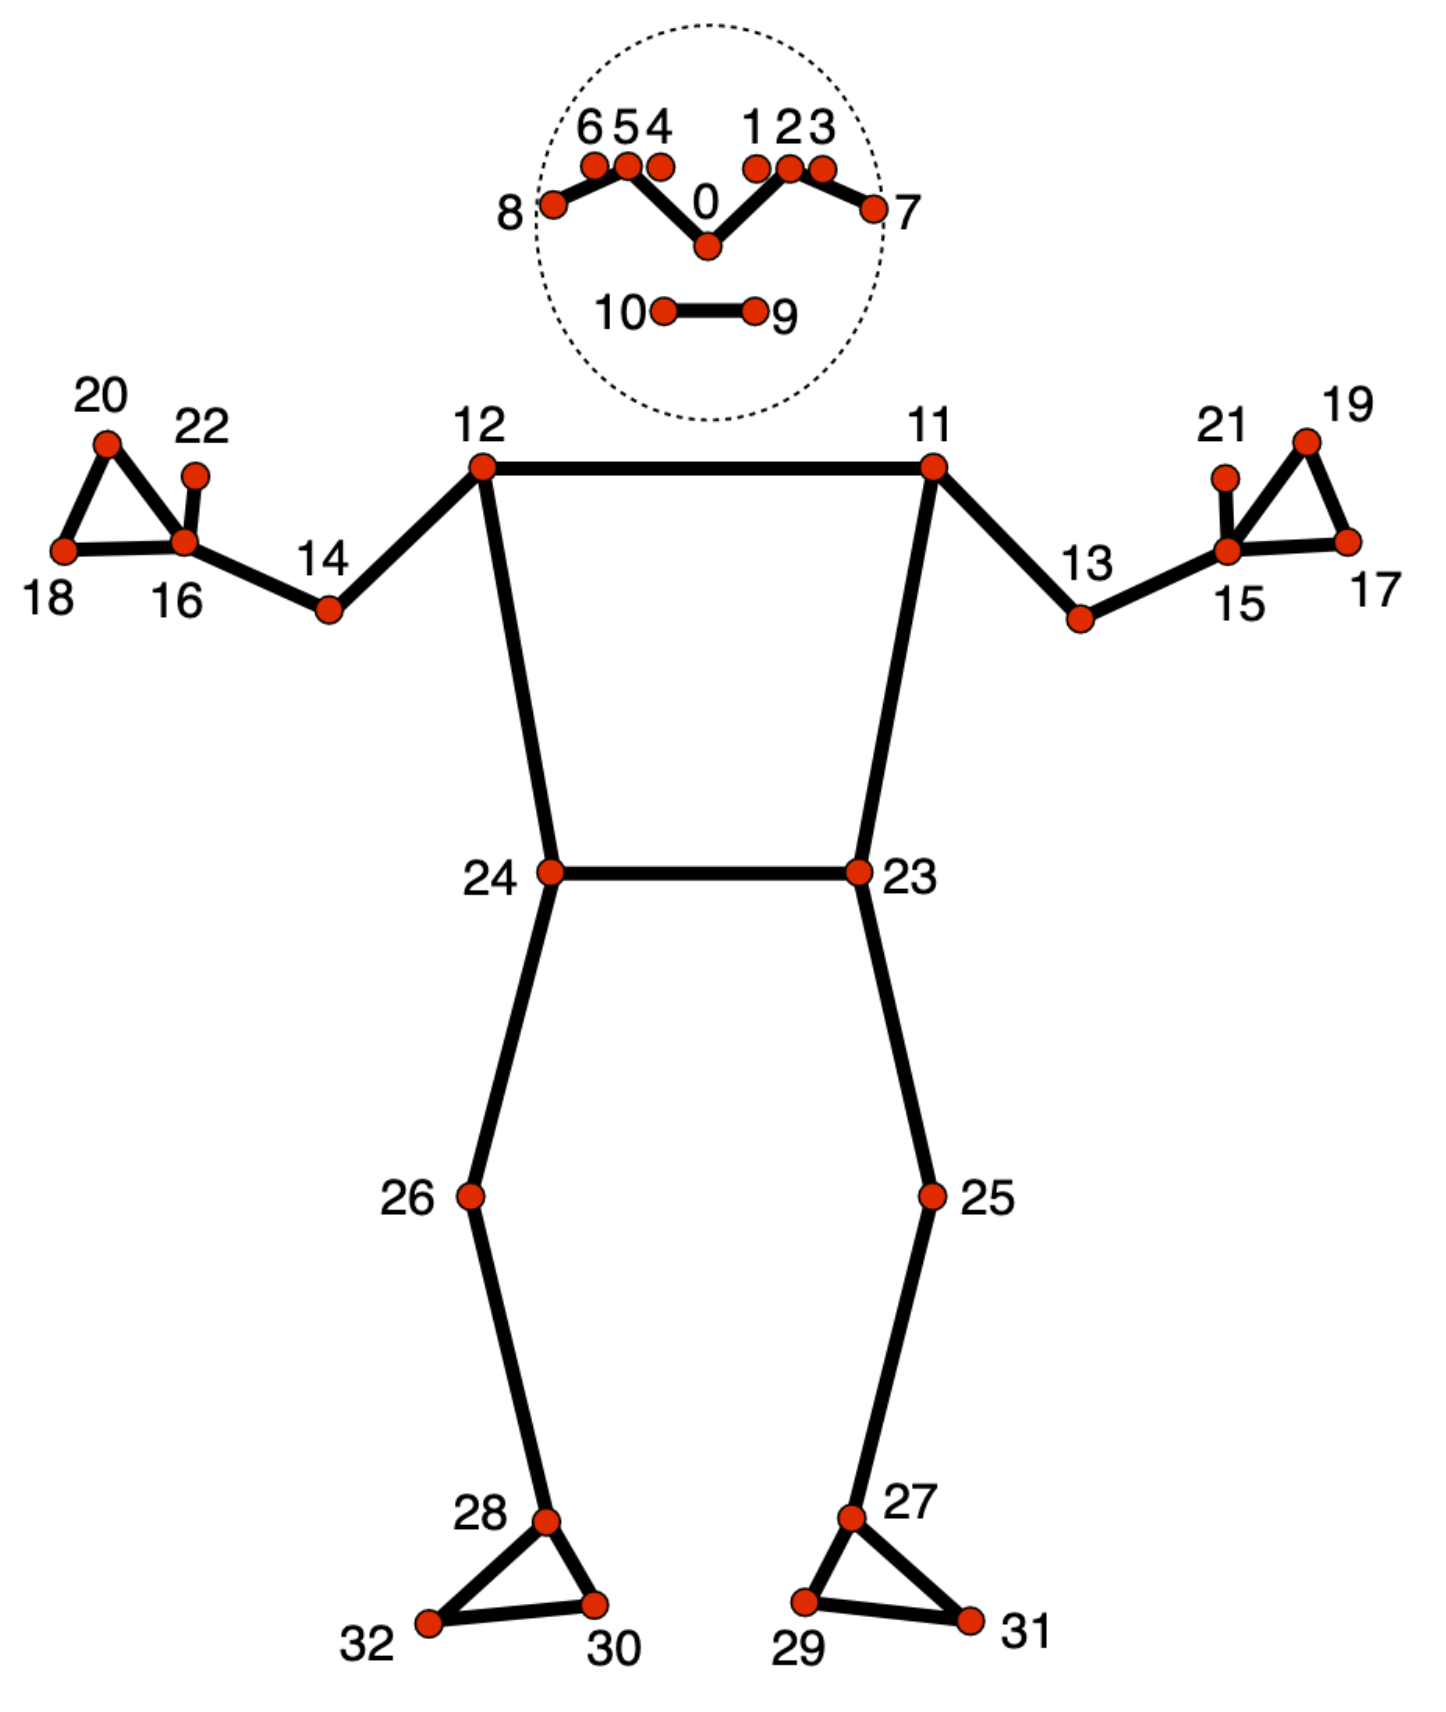

### 出力ファイル
- label　　（人物ラベル）
- point_ID　（トラクレットID，StrongSORTから取得した個別ＩＤ）
- file_name　（画像ファイル名，例　exp1_point1_100_0.9.jpg　）
- 〇_x　（〇はランドマーク，該当ランドマークの画像内のx座標，左上基準）
- 〇_ｙ  (該当ランドマークの画像内のy座標，左上基準）
- 〇_z  （該当ランドマークの画像内のz座標，または深度）
- 〇_v  （該当ランドマークの画像内の視認性，visabillity　０で最小，１で最大，値が大きいほど視認性が高い ）


In [ ]:
import glob
from natsort import natsorted
import os
import cv2
import math
import numpy as np
import csv
import mediapipe as mp
import pandas as pd


data_path = "C:/Users/sugie/PycharmProjects/StrongSORT-YOLO/data"
track_name = "exp3"
track_path = os.path.join(data_path, track_name)
track_list = os.listdir(track_path)
track_dir = [f for f in track_list if os.path.isdir(os.path.join(track_path, f))]
print("start_" + track_name)

# person内のフォルダリスト取得(ex:ichimanda,ichiraku...)
for exp in track_dir:
    person_path = os.path.join(track_path, exp, "crops/person/")
    filelist = []
    for d in os.listdir(person_path):
        if os.path.isdir(os.path.join(person_path, d)):
            filelist.append(d)
    person_list = os.listdir(person_path) # person内のフォルダリスト
    person_dir = [f for f in natsorted(person_list) if os.path.isdir(os.path.join(person_path, f))]
    print(person_path)

    # ID内の画像の全パスを取得(ex:name=1_1,1_7...  ex:ID_path=exp2_point1_489_0.94.jpg...)
    for name in person_dir:
        name_path = os.path.join(person_path, name)
        name_list = os.listdir(name_path)  # name内のリスト
        name_dir = [f for f in natsorted(name_list) if os.path.isdir(os.path.join(name_path, f))]
        firstloop = True
        first = True
        for ID in name_dir:
            ID_path = glob.glob(os.path.join(name_path, ID, "**"))  # ID_path=画像の絶対パスのリスト

            # 写真のリサイズ
            DESIRED_HEIGHT = 128
            DESIRED_WIDTH = 64

            def resize_and_show(image):
                h, w = image.shape[:2]
                if h < w:
                    img = cv2.resize(image, (DESIRED_WIDTH, math.floor(h / (w / DESIRED_WIDTH))))
                else:
                    img = cv2.resize(image, (math.floor(w / (h / DESIRED_HEIGHT)), DESIRED_HEIGHT))
                # cv2.imshow(img)

            # Read images with OpenCV.
            images = {names: cv2.imread(names) for names in ID_path}

            # 画像のプレビュー．
            # for names, image in images.items():
            #     print(names)
            #     resize_and_show(image)

            mp_pose = mp.solutions.pose
            mp_drawing = mp.solutions.drawing_utils
            mp_drawing_styles = mp.solutions.drawing_styles

            # 完成版
            # 3次元座標の取得(pose_world_landmarks:お尻を中心とした座標系)

            # CSVのヘッダを準備
            def fields_name():
                fields = []
                fields.append("point_ID")
                fields.append('file_name')
                for i in range(33):
                    fields.append(str(i) + '_x')
                    fields.append(str(i) + '_y')
                    fields.append(str(i) + '_z')
                    fields.append(str(i) + '_v')
                return fields

            # 保存先の用意
            os.makedirs("./orientation", exist_ok=True)
            save_csv_dir = os.path.join("./orientation", track_name + "_3Dlandmark_csv", "csv_" + name)
            os.makedirs(save_csv_dir, exist_ok=True)
            save_csv_name = track_name + "_3Dlamdmark_" + name + ".csv"

            with mp_pose.Pose(
                static_image_mode=True, min_detection_confidence=0.5, model_complexity=2) as pose, \
                     open(os.path.join(save_csv_dir, save_csv_name), 'a', encoding='utf-8', newline="") as f:
                        cwriter = csv.DictWriter(f, fieldnames=fields_name())
                        cwriter.writeheader()
                        for filename, image in images.items():
                            try:
                                if image is None:
                                    print(f"Image {filename} not loaded correctly.")
                                    continue
                                h, w = image.shape[:2]
                                if h == 0 or w == 0:
                                    print(f"Image {filename} has invalid dimensions: ({h}, {w}).")
                                    continue
                                if h < w:
                                    if w / h / DESIRED_WIDTH == 0:
                                        print(f"Invalid scale for image {filename}.")
                                        continue
                                    image = cv2.resize(image, (DESIRED_WIDTH, math.floor(h / (w / DESIRED_WIDTH))))
                                else:
                                    if h / w / DESIRED_HEIGHT == 0:
                                        print(f"Invalid scale for image {filename}.")
                                        continue
                                    image = cv2.resize(image, (math.floor(w / (h / DESIRED_HEIGHT)), DESIRED_HEIGHT))
                                results = pose.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

                                if not results.pose_world_landmarks:
                                    continue

                                record = {}
                                record["file_name"] = os.path.basename(filename)
                                record["point_ID"] = os.path.basename(os.path.dirname(filename))
                                for i, landmark in enumerate(results.pose_world_landmarks.landmark):
                                    record[str(i) + '_x'] = landmark.x
                                    record[str(i) + '_y'] = landmark.y
                                    record[str(i) + '_z'] = landmark.z
                                    record[str(i) + '_v'] = landmark.visibility
                                cwriter.writerow(record)
                            except Exception as e:
                                print(f"Error processing image {filename}: {e}")

# csvの結合
save_csv_name = track_name + "3Dlandmark_all.csv"
csv_path = os.path.join("C:/Users/sugie/PycharmProjects/mediapipe/orientation", track_name + "_3Dlandmark_csv")
csv_list = os.listdir(csv_path)
firstloop = True
count = 0
for csv_data in csv_list:
    csv_namelist = glob.glob(os.path.join(csv_path, csv_data, "**"))
    print(csv_namelist)
    if not csv_namelist:
        continue
    csv_name = csv_namelist[0]
    count_col_list = [0]
    if firstloop:
        df = pd.read_csv(csv_name)
        count_col = count_col_list * len(df)
        df.insert(loc=0, column='label', value=count_col)
        firstloop = False
    elif "other" in csv_name:
        df2 = pd.read_csv(csv_name)
        count_col2 = count_col_list * len(df2)
        df2.insert(loc=0, column="label", value=count_col2)
        df = pd.concat([df, df2])
    else:
        count = count + 1
        count_col_list2 = [count]
        df2 = pd.read_csv(csv_name)
        count_col2 = count_col_list2 * len(df2)
        df2.insert(loc=0, column="label", value=count_col2)
        df = pd.concat([df, df2])
df = df[df['point_ID'] != "point_ID"]

df.to_csv(os.path.join(csv_path, save_csv_name), index=False)
print("complete_" + track_name)


# 全身が映らない人物画像を削除する

山崎の論文より，ReIDモデルの訓練データから全身が映らない人物の画像を削除するとReID精度が向上することが分かっている．よって，全身を代表する主要関節において視認性（visavility）が閾値0.5をした回るランドマークが３つ以上あるサンプルを削除する．

- 主要関節座標　11-16, 23-28


In [ ]:
import os
import pandas as pd
import glob
#result_combineにあるcsvフォルダ全てにdelete_vを行う
def process_file(data_path):
    data_reader = pd.read_csv(data_path, chunksize=500)
    df = pd.concat((r for r in data_reader), ignore_index=True)

    for i in range(11):
        df = df.drop([str(i) + "_x", str(i) + "_y", str(i) + "_z", str(i) + "_v"], axis=1)
    for i in range(29, 33):
        df = df.drop([str(i) + "_x", str(i) + "_y", str(i) + "_z", str(i) + "_v"], axis=1)
    for i in range(17, 23):
        df = df.drop([str(i) + "_x", str(i) + "_y", str(i) + "_z", str(i) + "_v"], axis=1)

    dir_name = data_path + "_delete"
    os.makedirs(dir_name, exist_ok=True)
    save_csv_name = "delete_xyz_" + os.path.basename(data_path)
    df.to_csv(dir_name + "/" + save_csv_name, index=False)

    data_path = os.path.join(dir_name, "delete_xyz_" + os.path.basename(data_path))

    data_reader = pd.read_csv(data_path, chunksize=500)
    df = pd.concat((r for r in data_reader), ignore_index=True)

    for i, row in df.iterrows():
        skip = True
        count = 0
        # 上半身
        for j in range(11, 17):
            if row[str(j) + "_v"] < 0.5:
                count = count + 1
        # 下半身
        for k in range(23, 29):
            if row[str(k) + "_v"] < 0.5:
                count = count + 1
        if count >= 3:
            df = df.drop([i])

    dir_name = data_path + "_whole"
    os.makedirs(dir_name, exist_ok=True)
    save_csv_name = "whole_" + os.path.basename(data_path)
    df.to_csv(dir_name + "/" + save_csv_name, index=False)

# 主要関節の抜き出し（v込み）
all_files = glob.glob("C:/Users/sugie/PycharmProjects/mediapipe/result_combine/*")

for file_path in all_files:
    process_file(file_path)
